<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 6: Feature Engineering </h2>
<br>

This notebook explores a few useful feature engineering tools for structured data. Remember that feature engineering is highly dependent on the context and the model. There may be multiple good ways to work with a dataset.  You should use your analytical skills to build interesting models for each situation.

Each specific step in feature engineering may not make much difference for the performance of the final model. However, these small improvements can add up to a substantial increase in accuracy, justifying the effort. 

<a href="#1.-Ames-Housing-Data">Ames Housing Data</a> <br>
<a href="#2.-Data-cleaning">Data cleaning</a> <br>
<a href="#3.-Data-types">Data types</a> <br>
<a href="#4.-Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a href="#5.-Response-variable">Response variable</a> <br>
<a href="#6.-Outliers">Outliers</a> <br>
<a href="#7.-Continuous-predictors">Continuous predictors</a> <br>
<a href="#8.-Nominal-predictors">Nominal predictors</a> <br>

This notebook relies on the following imports and settings. 

In [88]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# this is to clear the warnings from this page, usually we should leave this on

In [89]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [90]:
# Methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

## 1. Ames Housing Data

### 1.1 Data and business understanding
We use data the Ames Housing data from [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), which contains detailed information about residential property sales in a North American city. It is used in one of the most popular practice competitions on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) on Kaggle. 

The dataset has 81 predictor variables of all standard types (continuous, discrete, nominal, and ordinal), allowing for lots of creative feature engineering. See the [documentation](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) for a description of the original variables. 

The objective is to predict the sale prices (the last column in the dataset). We assume that the loss function is the squared error loss on the log scale. That implies that we care about the percentage errors in the predictions (approximately), rather than the errors measured in dollars. 

In [91]:
data=pd.read_csv('Data/AmesHousing.csv')
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### 1.2 Training-Validation Split

To keep things simple, we treat the entire data as training data in this tutorial. However, we create a validation set to iteratively experiment with feature engineering. A validation set is a subset of the training data that we set aside for model selection. We fit the models on the training set, and compute the predictions for the validation set. 

We create a validation set in the exact same way that we create a test set. The difference is in the purpose. The validation set is for model selection, and the test set is for model evaluation. You cannot do both at the same time because then the evaluation would not be correct.

In [92]:
index_train, index_val  = train_test_split(data.index, train_size = 0.7, random_state=15)

## 2. Data cleaning

Data frequently have errors, so we should try to detect and fix them early on. Consider for example the `GarageYrBlt` variable. 

In [93]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [94]:
data['GarageYrBlt'].describe().round(0)

count    2771.0
mean     1978.0
std        26.0
min      1895.0
25%      1960.0
50%      1979.0
75%      2002.0
max      2207.0
Name: GarageYrBlt, dtype: float64

The maximum value is a typing error that we can easily fix.

In [95]:
data['GarageYrBlt']
data.loc[data['GarageYrBlt']==2207, 'GarageYrBlt'] = 2007

The [dabl](https://dabl.github.io/dev/generated/dabl.detect_types.html#dabl.detect_types) package tries to automatically detect the column types, which can help with data cleaning and identifying data types. 

In [97]:
from dabl import detect_types
types = detect_types(data)
types.head()

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
MSSubClass,False,False,True,False,False,False,False
MSZoning,False,False,False,True,False,False,False
LotFrontage,True,False,False,False,False,False,False
LotArea,True,False,False,False,False,False,False
Street,False,False,False,False,False,False,True


Let's check why `dabl` considered `Street` to be "useless".

In [98]:
data['Street'].value_counts()

Pave    2918
Grvl      12
Name: Street, dtype: int64

In [99]:
data['Street'].value_counts()/len(data)

Pave    0.995904
Grvl    0.004096
Name: Street, dtype: float64

#### An Aside

<p style="color:blue">
A note on the quality of the data: Notice that the `Street` predictor is nothing, but it sure is useless.</p>

<p style="color:blue">This is essential a case of over-representation. It makes is useless because there is not enough diversity in this predictor to actually be respresentive of any underlying pattern.

This, of course, is not always true and you have to be careful when doing this. Specifically, if we look at what `dabl` considers to be "useless" we see that it considers `3SsnPorch` (Three season porch area in sq ft) and `PoolArea` (Pool Area in sq ft). I have no idea what a 3 season porch area is, but it seems like something only an expensive house would have. So these two predictors they may <b> actually be useful </b> because I'd expect a pool to add value on a house.

In [30]:
types[types['useless']]

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
Street,False,False,False,False,False,False,True
Utilities,False,False,False,False,False,False,True
LandSlope,False,False,False,False,False,False,True
Condition2,False,False,False,False,False,False,True
RoofMatl,False,False,False,False,False,False,True
Heating,False,False,False,False,False,False,True
LowQualFinSF,False,False,False,False,False,False,True
KitchenAbvGr,False,False,False,False,False,False,True
GarageCond,False,False,False,False,False,False,True
3SsnPorch,False,False,False,False,False,False,True


In [32]:
data['PoolArea'].value_counts()/len(data)

0      0.995563
561    0.000341
555    0.000341
519    0.000341
800    0.000341
738    0.000341
648    0.000341
576    0.000341
512    0.000341
480    0.000341
444    0.000341
368    0.000341
228    0.000341
144    0.000341
Name: PoolArea, dtype: float64

#### And We Go Back
The `clean` function from `dabl` runs the same type detection, deletes "useless" variables, and applies conversions when a column has inconsistent type (such as a mix of numbers and strings).  This is just basic data processing to save some time. It won't fix data quality issues. 

In [100]:
from dabl import clean
data, types = clean(data, verbose=1, return_types=True)

Detected feature types:
11 float, 26 int, 43 object, 0 date, 0 other
Interpreted as:
continuous      22
dirty_float      0
low_card_int     6
categorical     40
date             0
free_string      0
useless         12
dtype: int64


We end up with 68 columns instead of the original 80.

In [101]:
data.shape

(2930, 68)

## 3. Data types

The `types` dataframe is now updated for the processed dataset.

In [102]:
types.head()

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
MSSubClass,False,False,True,False,False,False,False
MSZoning,False,False,False,True,False,False,False
LotFrontage,True,False,False,False,False,False,False
LotArea,True,False,False,False,False,False,False
Alley,False,False,False,True,False,False,False


Automatic methods can jump-start things, but it's essential to know the data and manually add information as needed. For example, `OverallQual` is an ordinal predictor (meaning that it is a categorial variable), but `dabl` cannot distinguish it from a discrete variable. 

In [103]:
types.loc['OverallQual']

continuous      False
dirty_float     False
low_card_int     True
categorical     False
date            False
free_string     False
useless         False
Name: OverallQual, dtype: bool

Starting with pre-filled information based on `types`, I created a final table of data types by inspecting the data and consulting the documentation. 

In [104]:
variables=pd.read_csv('Data/ames-variables.csv', index_col='variable')
variables.head()

,type
variable,
MSSubClass,nominal
MSZoning,nominal
LotFrontage,continuous
LotArea,continuous
Street,nominal


In [105]:
variables['type'].value_counts()

nominal       30
continuous    22
ordinal       17
discrete      10
response       1
Name: type, dtype: int64

This is all a bit of work, which is good because then there are lots of jobs in data analytics :).

## 4. Exploratory data analysis

We get pandas profiling to generate a minimal report.  From this we quickly learn for example that we are dealing with many variables that have a large proportion of missing values or zeros. 

In [20]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, minimal=True)
profile.to_widgets()

#### Aside

<p style="color:blue"> That is a whole lot of effort to find that there are some variables with a lot of missing values. Let's do it an easier way! </p>

In [40]:
data.isna().sum().sort_values(ascending = False).head()

PoolQC         2917
MiscFeature    2824
Alley          2732
Fence          2358
FireplaceQu    1422
dtype: int64

In [41]:
data.isna().sum().sort_values(ascending = False).head()/len(data)

PoolQC         0.995563
MiscFeature    0.963823
Alley          0.932423
Fence          0.804778
FireplaceQu    0.485324
dtype: float64

## 5. Response variable


### 5.1 EDA 

As common in this type of data, the sale price has a right skewed distribution with some outliers in the right tail. 

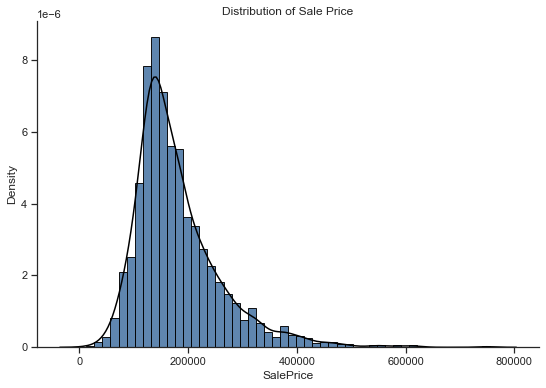

In [106]:
from statlearning import plot_dist
fig, ax  = plot_dist(data['SalePrice'])
ax.set_title('Distribution of Sale Price')
plt.show()

In [107]:
data['SalePrice'].skew()

1.7435000757376466

In [108]:
data['SalePrice'].kurtosis()

5.118899951130896

It's often instructive to explore the bivariate relationship between the response and predictors that have strongest relationship with it. We use the correlation coefficient to find such predictors here.

In [25]:
response = 'SalePrice'
data.corr()[response].abs().sort_values(ascending=False).head(5).round(3)

SalePrice      1.000
OverallQual    0.799
GrLivArea      0.707
GarageCars     0.648
GarageArea     0.640
Name: SalePrice, dtype: float64

Interestingly, `OverallQual` is an ordinal predictor so technically the correlation coefficient does not even apply! Let's work with `GrLivArea` since it is the continuous predictor with the largest correlation.

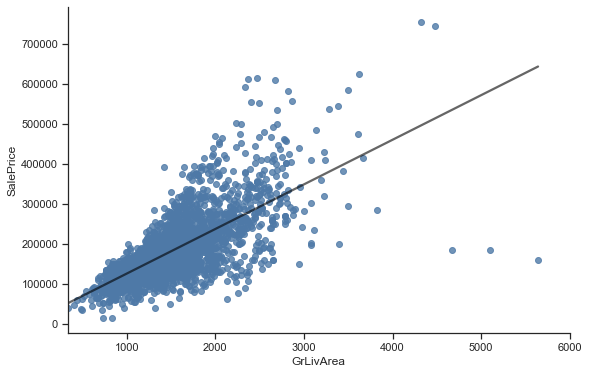

In [109]:
y, x = 'SalePrice', 'GrLivArea'  # doing this makes the rest of the cell reusable
ax = sns.regplot(data[x], data[y], ci=None, line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_xlim(None, 6000)
sns.despine()
plt.show()

That's the same funnel-shaped pattern that you saw in the lecture in context of a marketing application. The plot suggests non-constant error variance and some apparent outliers and leverage points. There's usually some nonlinearity and error skewness in this type of data.

### 5.2 Response transformation

Transforming the response variable can stabilise the variance, reduce skewness, and account for some of the nonlinearity. 

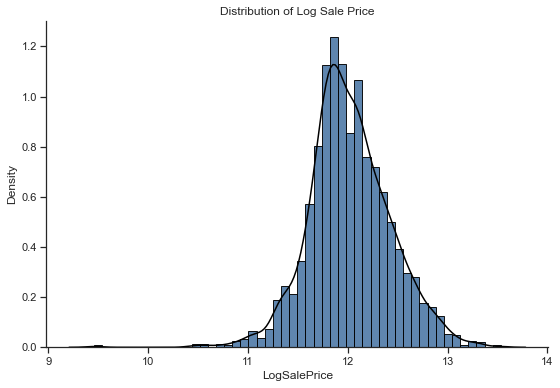

In [110]:
data['LogSalePrice'] = np.log(data['SalePrice'])
response = 'LogSalePrice'

fig, ax  = plot_dist(data[response])
ax.set_title('Distribution of Log Sale Price')
plt.show()

In [112]:
print(data['LogSalePrice'].skew())
print(data['SalePrice'].skew())

-0.014793439509736364
1.7435000757376466


In [111]:
print(data['LogSalePrice'].kurtosis())
print(data['SalePrice'].kurtosis())

1.513906773958983
5.118899951130896


The transformed variable is approximately symmetric, but there are two outliers on the left tail. 

Plotting the log of the sale price against the ground living area shows that the transformation stabilises the variance of the errors. 

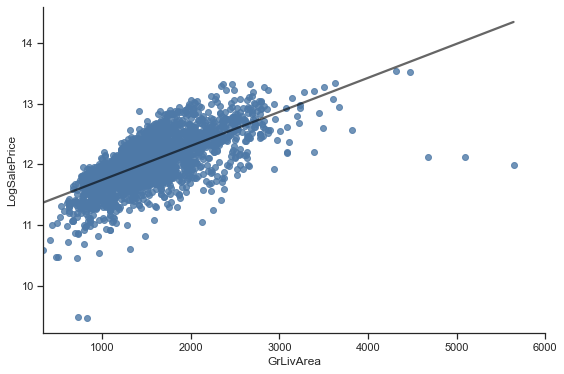

In [113]:
y, x = 'LogSalePrice', 'GrLivArea'  # doing this makes the rest of the cell reusable
ax = sns.regplot(data[x], data[y], ci=None, line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_xlim(None, 6000)
sns.despine()
plt.show()

Because of the loss function is the squared error on the log scale, the response variable is effectively the log sale price in any case.   

## 6. Outliers

It's a good idea to inspect outliers early. The ones is our data may be a problem because they are also leverage points (values in the tail of the distribution of the predictor). 

The next cell identifies outliers by the largest residuals in the simple linear regression that we just did.

In [116]:
predictors = ['GrLivArea']
X_train, y_train = data.loc[:, predictors], data.loc[:, response]

ols = LinearRegression()
ols.fit(X_train, y_train)

y_fitted = ols.predict(X_train)
e = y_train - y_fitted

outliers = e.abs().sort_values().iloc[-5:].index # retrieves the indexes for the largest 5 residuals

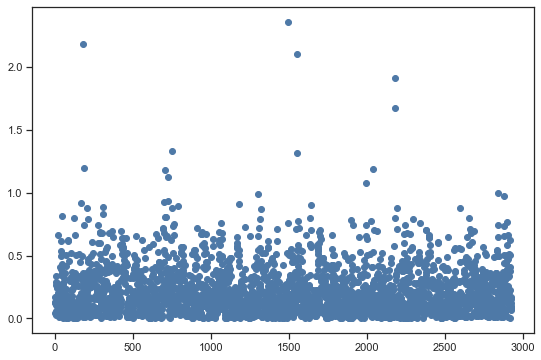

In [114]:
plt.plot(abs(e), 'o')

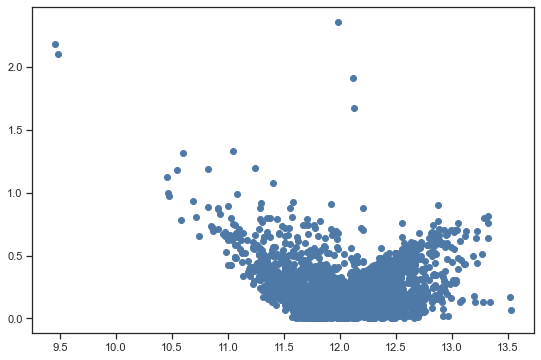

In [117]:
plt.plot(y_train, abs(e), 'o')

In [54]:
outliers

Int64Index([2181, 2180, 1553, 181, 1498], dtype='int64')

We can annotate the outliers on the figure.

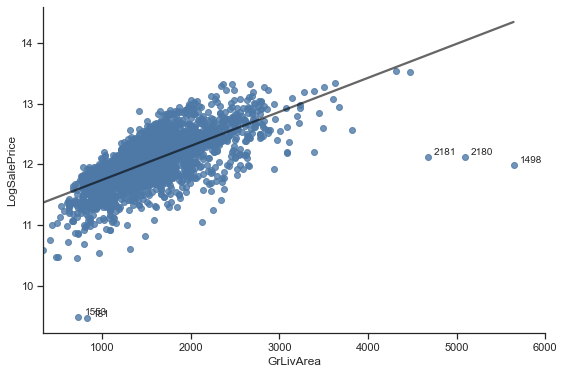

In [118]:
y, x = 'LogSalePrice', 'GrLivArea'  # doing this makes the rest of the cell reusable
ax = sns.regplot(data[x], data[y], ci=None, line_kws={'color':'black', 'alpha':0.6})
for i in outliers:
    ax.annotate(i, xy=(data.at[i,x], data.at[i,y]), xytext=(6,2) , textcoords ="offset points")
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_xlim(None, 6000)
sns.despine()
plt.show()


The fitted values are off by hundreds of thousands of dollars for some of these outliers. What's happening? 

#### An Aside
<p style="color:blue"> Sale Condition (Nominal): Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

#### And We Go Back

In [56]:
data.loc[outliers, ['SaleCondition','SalePrice']]

,SaleCondition,SalePrice
2181,Partial,184750
2180,Partial,183850
1553,Abnorml,13100
181,Abnorml,12789
1498,Partial,160000


Inspecting the data, we see that there are many partial and abnormal sales, so that we shouldn't completely dismiss those data points. 

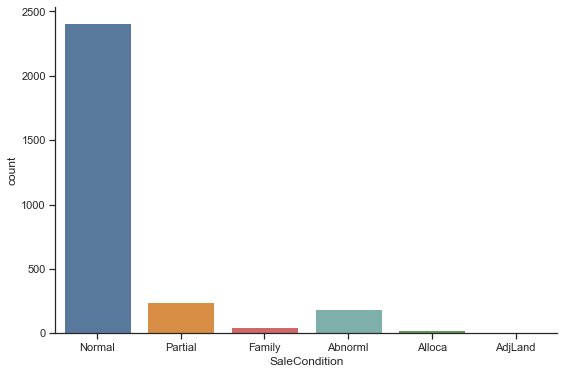

In [57]:
sns.countplot(data['SaleCondition'].astype(object))
sns.despine()
plt.show()

Ideally we should check if the outliers cause instability for estimation.  But let's keep it simple and remove them from the training set since the loss of data is negligible. 

In [119]:
index_train = index_train[~index_train.isin(outliers)] # note the tilde

## 7. Continuous Predictors

### 7.1 EDA

The distribution of `GrLivArea` is a bit right skewed, suggesting that a transformation might be useful as a feature for linear regression.

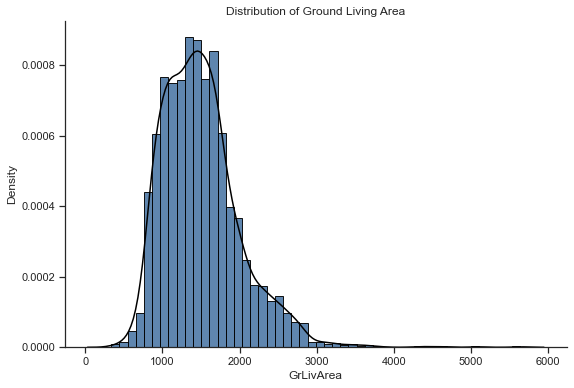

In [59]:
fig, ax  = plot_dist(data['GrLivArea'])
ax.set_title('Distribution of Ground Living Area')
plt.show()

### 7.2 Yeo-Johnson transformation

Here's how to do the Yeo-Johnson transformation. 

In [93]:
# Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer

predictors = ['GrLivArea']
X_train = data.loc[index_train, predictors]
X_val = data.loc[index_train, predictors]


yj = PowerTransformer(method='yeo-johnson') # YJ is the default, this function also does Box-Cox
X_train  = yj.fit_transform(X_train)
X_val = yj.transform(X_train)

In [120]:
# Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer

predictors = ['GrLivArea']
X_train = data.loc[index_train, predictors]

yj = PowerTransformer(method='yeo-johnson') # YJ is the default, this function also does Box-Cox
yj_transformed  = yj.fit_transform(X_train)

#### An Aside

<p style="color:blue"> Lets plot the newly transformed data and see what the Yeo-Johnson Transformation actually did.

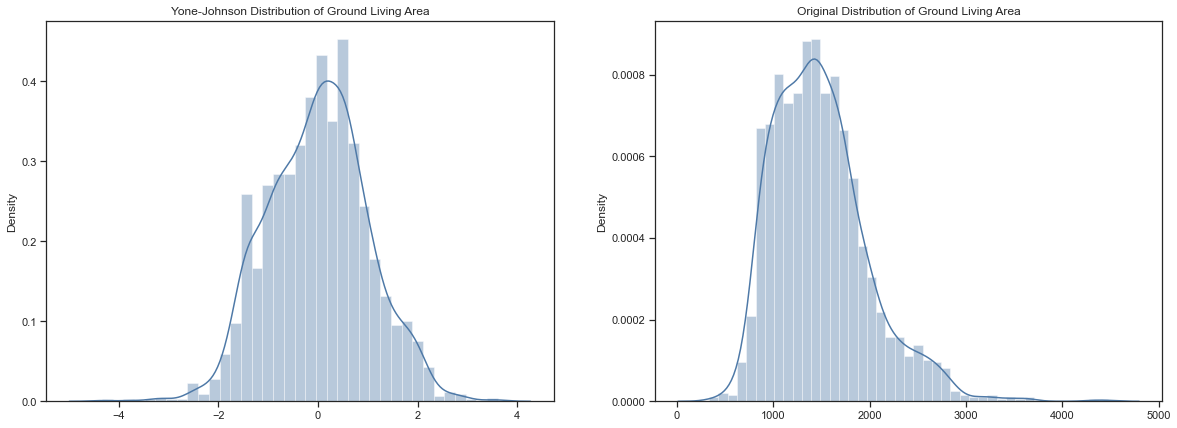

In [121]:
fig = plt.figure(figsize = (20, 7))

plt.subplot(1, 2, 1)
sns.distplot(yj_transformed)
plt.title('Yone-Johnson Distribution of Ground Living Area')

plt.subplot(1, 2, 2)
sns.distplot(X_train)
plt.title('Original Distribution of Ground Living Area')
plt.show()

fig.tight_layout();

Now plotting it against the `Y_train`, with a `loweless` (locally weighted linear regression).

#### An Aside From the Aside
The `loweless` parameter simply lets us see if there is any non-linearity in the data. If the `loweless` line becomes straight then we'd expect a linear model to work well. If the line is no straight then it'd suggest that there is some non-linearity in the data.

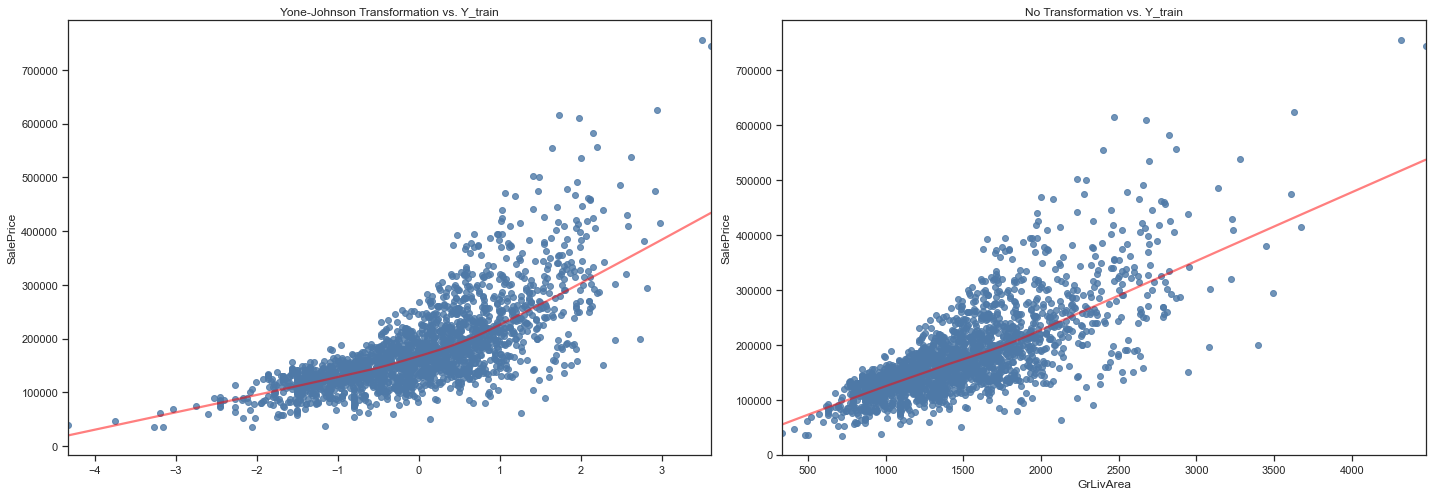

In [122]:
fig = plt.figure(figsize = (20, 7))

plt.subplot(1, 2, 1)
Y_train = data.loc[index_train, 'SalePrice']
sns.regplot(yj_transformed, Y_train, ci=None, lowess=True, line_kws={'color':'red', 'alpha':0.5})
plt.title('Yone-Johnson Transformation vs. Y_train')

plt.subplot(1, 2, 2)
sns.regplot(X_train, Y_train, ci=None, lowess=True, line_kws={'color':'red', 'alpha':0.5})
plt.title('No Transformation vs. Y_train');

fig.tight_layout();

We can see that the Yone-Johnson transformation actually does a really good job of 'stretching' the datapoints. <b> But it is now non-linear! </b> 

How can we fix this? We just learnt how, take log of `Y_train`.

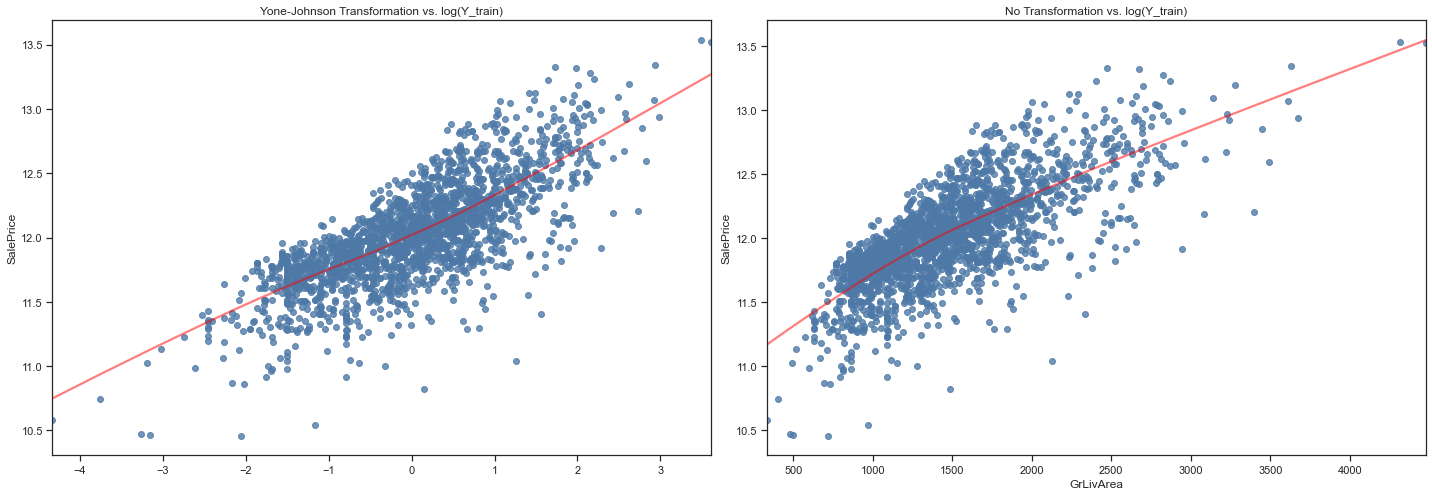

In [62]:
fig = plt.figure(figsize = (20, 7))

plt.subplot(1, 2, 1)
Y_train = data.loc[index_train, 'SalePrice']
sns.regplot(yj_transformed, np.log(Y_train), ci=None, lowess=True, line_kws={'color':'red', 'alpha':0.5})
plt.title('Yone-Johnson Transformation vs. log(Y_train)')

plt.subplot(1, 2, 2)
sns.regplot(X_train, np.log(Y_train), ci=None, lowess=True, line_kws={'color':'red', 'alpha':0.5})
plt.title('No Transformation vs. log(Y_train)');

fig.tight_layout();

Very Nice!

#### And We Go Back

### 7.3 Validation

Let's compare the validation set performance of the model without transformation, the log transformation, and the Yeo-Johnson transformation. 

When you experiment with feature engineering, it's better to have an easy way to test different combinations of features. Below, I write a function that gets the list of features to be used by different models and builds a table with the validation results. This will simplify things and save a lot of code in the rest of the tutorial.

In [123]:
# This code is more advanced, you don't have to worry about it
def validate(models):
    
    ols, X_val = dict(), dict()
    
    y_train = data.loc[index_train, 'LogSalePrice']

    for i in models.keys(): # looping over the keys of the dictionary
        X_train =  data.loc[index_train, models[i]]
        X_val[i] = data.loc[index_val, models[i]]
        ols[i] = LinearRegression().fit(X_train, y_train)

    # Initialise table
    rows = models.keys()
    columns=['RMSE', 'R-Squared', 'MAE']
    results = pd.DataFrame(0.0, columns=columns, index=rows)

    for i, key in enumerate(models.keys()):
        y_pred = ols[key].predict(X_val[key])
        results.iloc[i, 0] = np.sqrt(mean_squared_error(y_val, y_pred))
        results.iloc[i, 1] = r2_score(y_val, y_pred)
        results.iloc[i, 2] = mean_absolute_error(y_val, y_pred)

    return results.round(3)

We now apply it. 

In [124]:
# Response variable 
y_train = data.loc[index_train, response]
y_val = data.loc[index_val, response]

# Log transformation
data['GrLivAreaLog'] = np.log(data['GrLivArea'])

# Yeo-Johnson transformation
yj = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, ['GrLivArea']])
data['GrLivAreaYJ']  = yj.transform(data[['GrLivArea']])

# Dictionary of predictors for each model
models = dict()
models['No transformation'] = ['GrLivArea']
models['Log'] = ['GrLivAreaLog'] 
models['Yeo-Johnson'] = ['GrLivAreaYJ']

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
No transformation,0.314,0.432,0.232
Log,0.308,0.454,0.230
Yeo-Johnson,0.308,0.454,0.229


Transforming helps, but the fitted Yeo-Johnson transformation is essentially a log transformation. 

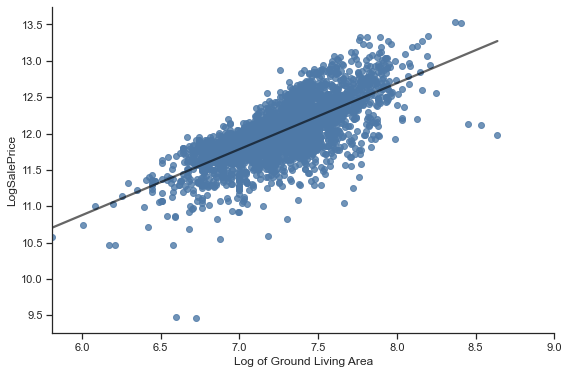

In [125]:
y, x = 'LogSalePrice', 'GrLivAreaLog'  # doing this makes the rest of the cell reusable
ax = sns.regplot(data[x], data[y], ci=None, line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel('Log of Ground Living Area')
ax.set_ylabel(y)
ax.set_xlim(None, 9)
sns.despine()
plt.show()

It's interesting to inspect the distribution of the transformed predictor. It's nearly symmetric, without outliers.

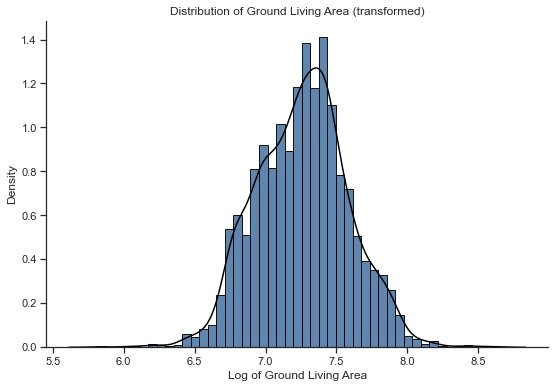

In [66]:
fig, ax  = plot_dist(data[x])
ax.set_title('Distribution of Ground Living Area (transformed)')
ax.set_xlabel('Log of Ground Living Area')
plt.show()

In [126]:
continuous = ['GrLivAreaLog']

## 8. Nominal predictors

### 8.1 EDA

Take `Neighbourhood` as the example. 

In [127]:
data['Neighborhood'].describe()

count      2930
unique       28
top       NAmes
freq        443
Name: Neighborhood, dtype: object

In [128]:
data['Neighborhood'].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

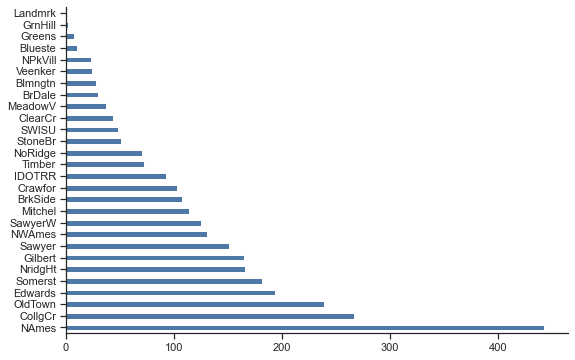

In [70]:
data['Neighborhood'].value_counts().plot(kind='barh')
sns.despine()
plt.show()

### 8.2 Sparse categories

The first detail that we note is that some neighbourhoods have very few observations. Therefore, we merge them into an "other" category.  

#### Aside
Lets try the naive way, setting all the rows with less than 10 counts equal to `'Other'`

In [42]:
variable = 'Neighborhood'

counts = data[variable].value_counts() 
for level in counts.index:
    if counts[level] < 10:
        data.loc[data[variable]==level, variable] = 'Other'

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

It doesn't work. So we need to add `'Other'` to the list of categories first.

In [129]:
variable = 'Neighborhood'
data[variable].cat.add_categories('Other', inplace=True)

In [130]:
data[variable].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Other        0
Name: Neighborhood, dtype: int64

Now that `'Other'` is offical a category, we can now swap the categoreis that are less than 10 to `'Other'`.

In [131]:
counts = data[variable].value_counts() 
for level in counts.index:
    if counts[level] < 10:
        data.loc[data[variable]==level, variable] = 'Other'

In [132]:
data[variable].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Other       11
Blueste     10
Greens       0
GrnHill      0
Landmrk      0
Name: Neighborhood, dtype: int64

It is now in there! Finally, we need to remove the unused categories

In [133]:
data[variable].cat.remove_unused_categories(inplace=True)

In [134]:
data[variable].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Other       11
Blueste     10
Name: Neighborhood, dtype: int64

### 8.3 One-hot and dummy encoding

The next cell shows you how to one-hot encode the nominal variable. 

In [137]:
# note: you can also do this with scikit-learn
variable = 'Neighborhood'
dummies = pd.get_dummies(data[variable],  prefix = variable)
dummies.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_Other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Since we need dummy encoding for the linear regression model, we add the `drop_first=True` to remove one of the columns.  We then merge the dummies into the original dataframe and update the list of predictors. 

In [138]:
variable = 'Neighborhood'
dummies = pd.get_dummies(data[variable],  prefix = variable, drop_first = True)
dummies.head()

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_Other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
variable = 'Neighborhood'
dummies = pd.get_dummies(data[variable],  prefix = variable, drop_first=True)
data = data.join(dummies)
nominal_dummies = list(dummies.columns) 

### 8.4 High cardinality

Dummy encoding lead us to build many dummy variables, which can contribute to overfitting.  Let's experiment with a generalised linear mixed model encoder, which works as an approximation to using a statistical model that is designed for this situation. 

#### An Aside - On Encoding (There is an entire field of ML and Mathematics that is loosly based on this)
All encoding means is to <b> re-represent </b> something with something else. 

The easiest way to do this is dummy variables. Using dummy variables we <b> re-represent </b> a list of the form `['Central', 'Redfern', 'Town Hall', 'Strathfield', 'Burwood']` with the new list `[(1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0), (0, 0, 0, 1), (0, 0, 0, 0)]`. So the new representation is

    Central     -> (1, 0, 0, 0)
    Redfern     -> (0, 1, 0, 0)
    Town Hall   -> (0, 0, 1, 0)
    Strathfield -> (0, 0, 0, 1)
    Burwood     -> (0, 0, 0, 0)
    
So using dummy variables is one way to represent it. BUT, we can use a different way to <b> represent </b> these cities. Consider the following <b> representation </b> or encodings:

    Central     -> (8708, 2073)
    Redfern     -> (8930, 2054)
    Town Hall   -> (8732, 2061)
    Strathfield -> (8775, 0824)
    Burwood     -> (8774, 1037)

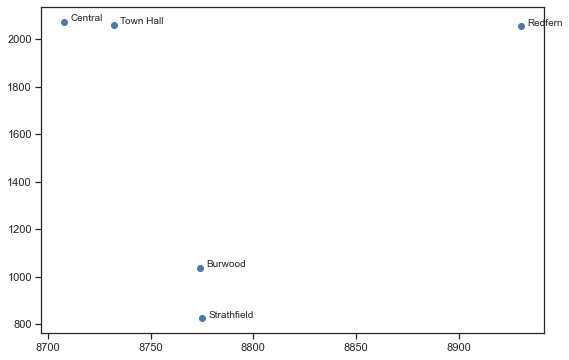

In [83]:
fig, ax = plt.subplots()

points = [(8708, 2073), (8930, 2054), (8732, 2061), (8775, 824), (8774, 1037)]
cities = ['Central', 'Redfern', 'Town Hall', 'Strathfield', 'Burwood']

ax.scatter([x for x, y in points], [y for x, y in points])
for point, city in zip(points, cities):
    ax.annotate(city, (point[0] + 3, point[1] + 3))

I'll leave it for you to figure out how I got these encodings (think latitude and longitude). But this is a new <b> representation </b> of `Central, Redfern, ...` which we can use instead of the dummy variables. But, the benefit of using this encoding is that it preserves distance. Namely `Central, Redfern, Town Hall` are clearly very close to each other, and `Stratfield, Burwood` are close to each other, but very far away from `Central, Redfern, Town Hall`. As is true in real life.

Of couse, if you were to actually use this encoding, it'd be a good idea to rescale everything (use `StandardScalar`)

<b>Encodings are very important. Smart ways to encode will significantly boost model performance. While bad encodings will only hurt models.</b> For example, take the other encoding

    Central     -> C -> 3
    Redfern     -> R -> 18
    Town Hall   -> T -> 20
    Strathfield -> S -> 19
    Burwood     -> B -> 2

This is just an alphabetical encoding. From a technical perspective, there is no reason why this encoding will not work. But, I hope, we all recognise this encoding is nonsensical. Then by using this encoding, although theoretically sounds, will not deliver good results.

So make sure your encodings makes sense. Often times dummy variables will make sense. But if you always use dummy variables for encodings, then you will prove to be the dummy.

There are many other ways to re-represent items. If you know deep learning, Variational Auto-Encoders is the hottest topic of langage encodings. But, in this tutorial we will used the GLMMEncoder.

#### And We Go Back

In [140]:
from category_encoders.glmm import GLMMEncoder

X_train = data.loc[index_train, 'Neighborhood']

glmm = GLMMEncoder().fit(X_train, y_train) # we must use the training set for this
data['NeighborhoodGLMM'] = glmm.transform(data['Neighborhood'])

This method encodes the nominal predictor with an estimate of how much mean sale price for that neighbourhood deviates from the mean of all neighbourhoods. We're not really "supposed" to use the response to help build features, but this type of encoding can be useful in practice when there are many distinct labels. 

In [141]:
data['Neighborhood'].unique()

['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'Somerst', ..., 'Blueste', 'Mitchel', 'Timber', 'MeadowV', 'Veenker']
Length: 26
Categories (26, object): ['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', ..., 'Mitchel', 'Timber', 'MeadowV', 'Veenker']

In [142]:
sorted(data['NeighborhoodGLMM'].unique())

[-0.5810079534598946,
 -0.5149722464542007,
 -0.43569076090730663,
 -0.3595108628897483,
 -0.33606102753726824,
 -0.3349880992388537,
 -0.23074393826158204,
 -0.21442590338555984,
 -0.21222458149659876,
 -0.189128538414487,
 -0.17322833019254263,
 -0.044900529359656736,
 0.05843607938635494,
 0.09575553530488196,
 0.10383407497390566,
 0.12330782535899701,
 0.13909328904510174,
 0.1410550020549825,
 0.14214716387926163,
 0.15740313347346047,
 0.27086371549134736,
 0.3162327120057493,
 0.3198450448405062,
 0.5394974581879042,
 0.5939185799815044,
 0.6254931576911578]

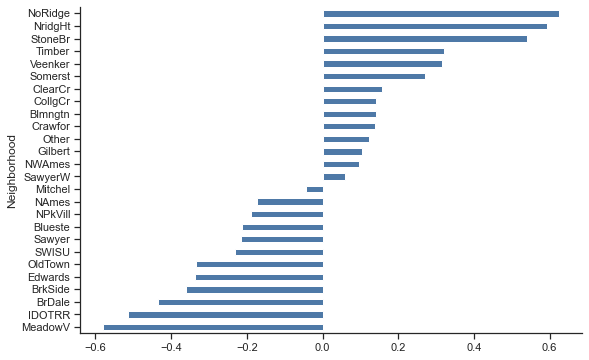

In [64]:
data.groupby('Neighborhood')['NeighborhoodGLMM'].mean().sort_values().plot(kind='barh')
sns.despine()
plt.show()

### 8.5 Validation

The neighbourhood variable contributes significantly to predictive accuracy. Dummy encoding does better that GLMM encoding, which is to be expected since the number of features is not large relative to the size of the data. The fact that GLMM doesn't do much worse suggests that it might be helpful overfitting becomes a concern.

In [143]:
# Dictionary of predictors for each model
models = dict()
models['Baseline'] = continuous # GrLivArea transformed
models['Dummy encoding'] = continuous + nominal_dummies
models['GLMM encoding'] =  continuous + ['NeighborhoodGLMM']

# Model validation
results = validate(models)
results

,RMSE,R-Squared,MAE
Baseline,0.308,0.454,0.230
Dummy encoding,0.214,0.738,0.152
GLMM encoding,0.220,0.722,0.158


## 9. Saving the data

We've done a lot already, so let's save the data to keep working on it another time. 

In [66]:
data.to_hdf('Data/Ames.h5', 'data', format='table')

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [67]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [68]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')

FileNotFoundError: [Errno 2] No such file or directory: 'css\\jupyter.css'